In [18]:
import numpy as np  
import matplotlib.pyplot as plt
import gymnasium as gym
import time
import os
from collections import defaultdict

In [19]:
def epsilon_greedy(env,Q,epsilon):
  def policy(state):
    if state not in Q:
      return np.random.choice(env.action_space.n)
    else:
      if np.random.random() < epsilon:
        return np.random.choice(env.action_space.n)
      else:
        return np.argmax(Q[state])
  return policy

In [20]:
def next_state_probabilities(env,state,Q,epsilon):
  nA = env.action_space.n
  if state not in Q:
    return np.ones(nA)/nA
  else:
    probs = np.ones(nA)*epsilon/nA
    greedy_action = np.argmax(Q[state])
    probs[greedy_action] += (1 - epsilon)
    return probs
    

In [21]:
def nstep_expected_sarsa(env,numeps,epsilon,alpha,gamma,nstep):
  nA = env.action_space.n
  Q = defaultdict(lambda: np.zeros(nA))
  reward_history = np.zeros(numeps)
  for i in range(numeps):
    if i % 500:
      print(f'episode {i}')
    policy = epsilon_greedy(env,Q,epsilon)  
    state, _ = env.reset()
    done = False
    action = policy(state)
    buffer = []
    t = 0
    T = float('inf')
    episode_reward = 0.0
    
    while not done:
      if t < T:
        tup = env.step(action)
        next_state,reward,term,trunc = tup[0], tup[1], tup[2], tup[3]
        done = term or trunc
        buffer.append((state,action,reward))
        episode_reward += reward
        if done:
          T = t + 1
        else:
          state = next_state
          action = policy(state)
          
      tau = t - nstep + 1
      if tau >= 0:
        G = 0
        j = min(T, tau + nstep)
        for k in range(tau + 1, j + 1):
          G += (gamma**(k-tau-1))*buffer[k-1][2]
          
        if tau + nstep < T:
          state_tau_n = buffer[tau + nstep -1][0]
          probs = next_state_probabilities(env,state_tau_n,Q,epsilon)
          expected_value = np.sum(probs*Q[state_tau_n])
          G += (gamma**nstep)*expected_value
        
        state_tau = buffer[tau][0]
        action_tau = buffer[tau][1]
        #update Q values
        Q[state_tau][action_tau] += alpha*(G - Q[state_tau][action_tau])
        
      t += 1
      if tau == T - 1:
        break
    reward_history[i] = episode_reward
      
  return Q, reward_history    
    

In [22]:
env = gym.make('CliffWalking-v0')
numactions = env.action_space.n
numstates = env.observation_space.n
print("Number of actions: ", numactions)
print("Number of states: ", numstates)

Number of actions:  4
Number of states:  48


In [23]:
numeps = 1000
epsilon = 0.1
alpha = 0.1
nsteps = 4
gamma = 1

In [24]:
Q, reward_history = nstep_expected_sarsa(env,numeps,epsilon,alpha,gamma,4)

episode 1
episode 2
episode 3
episode 4
episode 5
episode 6
episode 7
episode 8
episode 9
episode 10
episode 11
episode 12
episode 13
episode 14
episode 15
episode 16
episode 17
episode 18
episode 19
episode 20
episode 21
episode 22
episode 23
episode 24
episode 25
episode 26
episode 27
episode 28
episode 29
episode 30
episode 31
episode 32
episode 33
episode 34
episode 35
episode 36
episode 37
episode 38
episode 39
episode 40
episode 41
episode 42
episode 43
episode 44
episode 45
episode 46
episode 47
episode 48
episode 49
episode 50
episode 51
episode 52
episode 53
episode 54
episode 55
episode 56
episode 57
episode 58
episode 59
episode 60
episode 61
episode 62
episode 63
episode 64
episode 65
episode 66
episode 67
episode 68
episode 69
episode 70
episode 71
episode 72
episode 73
episode 74
episode 75
episode 76
episode 77
episode 78
episode 79
episode 80
episode 81
episode 82
episode 83
episode 84
episode 85
episode 86
episode 87
episode 88
episode 89
episode 90
episode 91
episode 

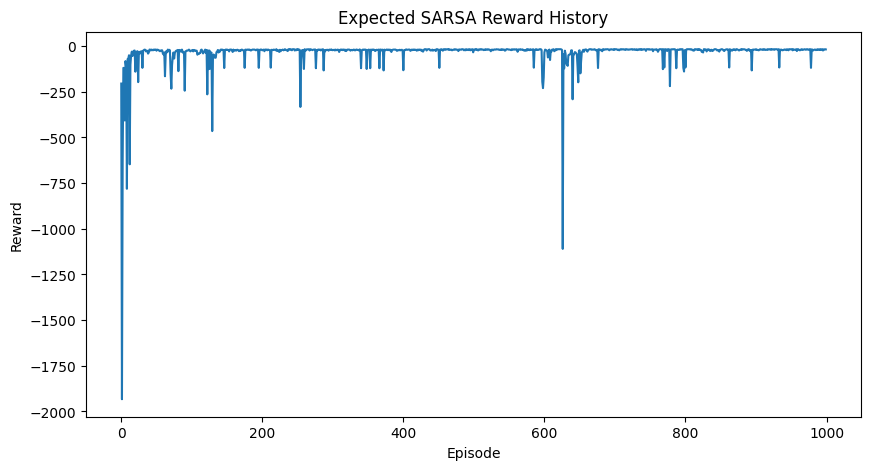

In [25]:
def plot_rewards(reward_history):
  plt.figure(figsize=(10, 5))
  plt.plot(reward_history)
  plt.xlabel("Episode")
  plt.ylabel("Reward")
  plt.title("Expected SARSA Reward History")
  plt.show()
plot_rewards(reward_history)

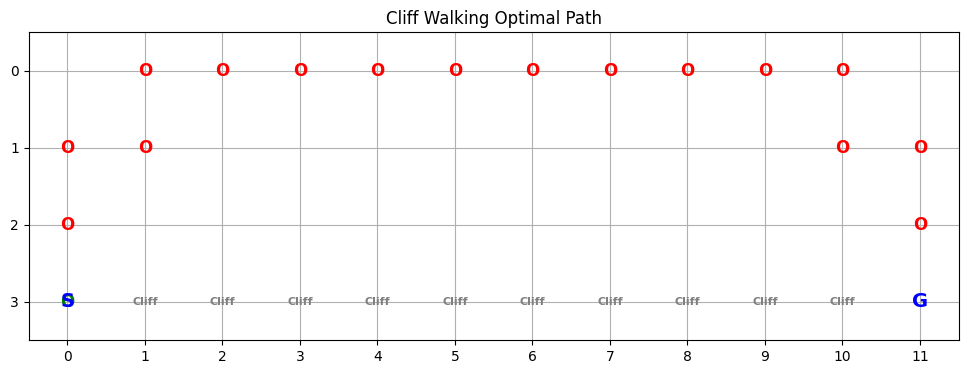

In [26]:
def plot_cliffwalking_paths(Q, env):
    grid_rows, grid_cols = 4, 12  # Grid dimensions for CliffWalking-v0
    start_state = 36  # Start state index
    goal_state = 47   # Goal state index

    # Initialize the grid
    grid = np.zeros((grid_rows, grid_cols), dtype=int)

    # Define the cliff area
    cliff_indices = np.arange(37, 47)
    for idx in cliff_indices:
        row, col = divmod(idx, grid_cols)
        grid[row, col] = -100  # Cliff cells

    # Compute the optimal path
    state, _ = env.reset()
    optimal_path = []
    done = False
    while not done:
        row, col = divmod(state, grid_cols)
        optimal_path.append((row, col))
        action = np.argmax(Q[state]) 
        tup = env.step(action)
        state, _, done, _ = tup if len(tup) == 4 else (tup[0], tup[1], tup[2], None)

    # Mark the start and goal positions
    start_row, start_col = divmod(start_state, grid_cols)
    goal_row, goal_col = divmod(goal_state, grid_cols)

    # Plot the grid
    plt.figure(figsize=(12, 4))
    for r in range(grid_rows):
        for c in range(grid_cols):
            if (r, c) in optimal_path:
                color = "red" if (r, c) != (start_row, start_col) and (r, c) != (goal_row, goal_col) else "green"
                plt.text(c, r, 'O', ha='center', va='center', color=color, fontsize=12, fontweight='bold')
            elif grid[r, c] == -100:
                plt.text(c, r, 'Cliff', ha='center', va='center', color='gray', fontsize=8, fontweight='bold')

    # Highlight start and goal
    plt.text(start_col, start_row, 'S', ha='center', va='center', color='blue', fontsize=14, fontweight='bold')
    plt.text(goal_col, goal_row, 'G', ha='center', va='center', color='blue', fontsize=14, fontweight='bold')

    # Draw the grid
    plt.xlim(-0.5, grid_cols - 0.5)
    plt.ylim(grid_rows - 0.5, -0.5)
    plt.xticks(range(grid_cols))
    plt.yticks(range(grid_rows))
    plt.grid(True)
    plt.title("Cliff Walking Optimal Path")
    plt.show()

# Plot the optimal path
plot_cliffwalking_paths(Q, env)
